(1000, 1, 28, 28) (1000,)
(2000, 1, 28, 28) (2000,)
1/5 0.7079308242826851
2/5 0.6385520492105796
3/5 0.5758876541497862
4/5 0.5329158121457938
5/5 0.48791513299434525
00 pred=1 actual=1
01 pred=1 actual=1
02 pred=1 actual=1
03 pred=1 actual=1
04 pred=0 actual=0
05 pred=1 actual=1
06 pred=0 actual=0
07 pred=0 actual=0
08 pred=1 actual=1
09 pred=1 actual=1


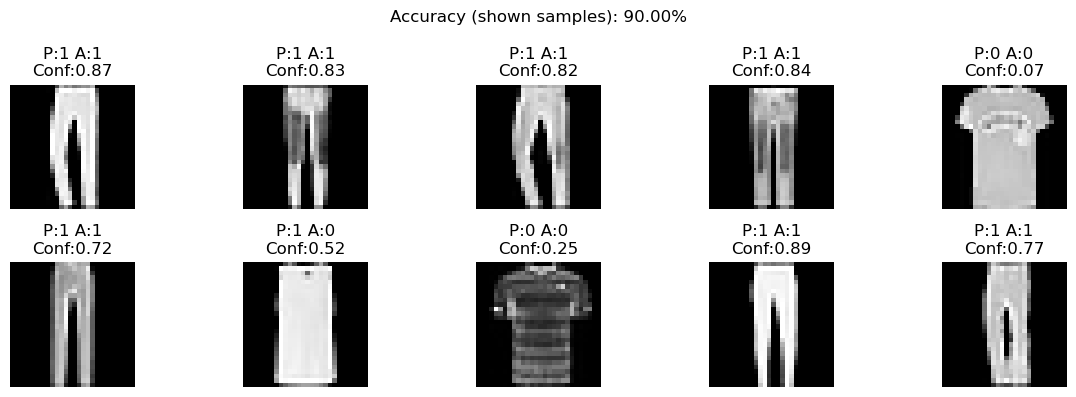

In [4]:
import numpy as np
from scipy import signal
def relu(x): return np.maximum(0,x)
def relu_der(x): return (x>0).astype(float)
def BCE_logits(y, z):
    return np.mean(np.maximum(z,0) - y*z + np.log(1+np.exp(-np.abs(z))))
def BCE_logits_der(y, z):
    return (1/(1+np.exp(-z)) - y) / y.size
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
class Layer:
    def forward(self, input):
        pass
    def backward(self, grad_output,lr):
        pass
class Dense(Layer):
    def __init__(self, inp, out):
        self.weight = np.random.randn(out, inp) * 0.1
        self.biases = np.zeros((out, 1))

    def forward(self, inp):
        self.inp = inp
        return np.dot(self.weight, self.inp) + self.biases
    def backward(self, out_grad, lr):
        weight_grad = np.dot(out_grad, self.inp.T)
        inp_grad = np.dot(self.weight.T, out_grad)
        self.weight -= lr * weight_grad
        self.biases -= lr * np.sum(out_grad, axis=0)
        return inp_grad

class Convolutional_Layer(Layer):
    def __init__(self, inp_shape, kernel_size, depth):
        inp_depth, inp_height, inp_width = inp_shape
        self.depth = depth
        self.inp_shape = inp_shape = inp_shape
        self.inp_depth = inp_depth
        self.out_shape = (depth, inp_height - kernel_size + 1, inp_width - kernel_size +1)
        self.kernels_shape= (depth, inp_depth, kernel_size, kernel_size)
        self.kernels = np.random.rand(*self.kernels_shape)
        self.biases = np.random.rand(*self.out_shape)
    def forward(self,inp):
        self.inp = inp
        self.out = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.inp_depth):
                self.out[i] += signal.correlate2d(self.inp[j], self.kernels[i,j], "valid")
        return self.out
    def backward(self, out_grad, lr):
        kernels_grad = np.zeros(self.kernels_shape)
        inp_grad = np.zeros(self.inp_shape)
        for i in range(self.depth):
            for j in range(self.inp_depth):
                kernels_grad[i,j] = signal.correlate2d(self.inp[j], out_grad[i], "valid")
                inp_grad[j] += signal.convolve2d(out_grad[i], self.kernels[i,j], "full")
        fan_in = np.prod(self.kernels_shape[1:])
        self.kernels = np.random.randn(*self.kernels_shape) * np.sqrt(2/fan_in)
        self.biases -= lr*out_grad
        return inp_grad

class Reshape(Layer):
    def __init__(self, inp, out):
        self.inp_shape = inp
        self.out_shape = out
    def forward(self, inp):
        return np.reshape(inp, self.out_shape)
    def backward(self, out_grad,lr):
        return np.reshape(out_grad, self.inp_shape)

def BCE(y_true, y_pred):
    return -np.mean(y_true*np.log(y_pred) + (1 - y_true)*np.log(1-y_pred))
def BCE_der(y_true, y_pred):
    return ((1-y_true)/(1-y_pred)-y_true/ y_pred)/ np.size(y_true)

class Activatoo(Layer):
    def __init__(self, act, act_der):
        self.act = act
        self.act_der = act_der
    def forward(self, inp):
        self.inp = inp
        return self.act(self.inp)
    def backward(self, out_grad, lr):
        return out_grad * self.act_der(self.inp)

class ReLU(Activatoo):
    def __init__(self):
        super().__init__(relu, relu_der)

class MaxPool(Layer):
    def forward(self, x):
        self.x = x
        C, H, W = x.shape
        self.out = np.zeros((C, H//2, W//2))
        self.max_pos = {}
        for c in range(C):
            for i in range(0, H, 2):
                for j in range(0, W, 2):
                    patch = x[c, i:i+2, j:j+2]
                    self.out[c, i//2, j//2] = np.max(patch)
                    self.max_pos[(c, i//2, j//2)] = np.unravel_index(np.argmax(patch), patch.shape)
        return self.out
    def backward(self, out_grad, lr):
        C, H, W = self.x.shape
        grad = np.zeros_like(self.x)
        for (c, i, j), (pi, pj) in self.max_pos.items():
            grad[c, 2*i + pi, 2*j + pj] = out_grad[c, i, j]
        return grad

import numpy as np
from torchvision.datasets import FashionMNIST
train = FashionMNIST(root="data", train=True, download=False)
test  = FashionMNIST(root="data", train=False, download=False)
x_train, y_train = train.data.numpy(), train.targets.numpy()
x_test,  y_test  = test.data.numpy(),  test.targets.numpy()
a, b = 0, 1
mask_tr = (y_train == a) | (y_train == b)
mask_te = (y_test  == a) | (y_test  == b)
x_train, y_train = x_train[mask_tr], (y_train[mask_tr] == b).astype(np.float32)
x_test,  y_test  = x_test[mask_te],  (y_test[mask_te]  == b).astype(np.float32)
x_train = (x_train / 255.0).reshape(-1, 1, 28, 28)
x_test  = (x_test  / 255.0).reshape(-1, 1, 28, 28)
x_train=x_train[:1000]
y_train=y_train[:1000]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

network = [
    Convolutional_Layer((1,28,28),3,4),
    ReLU(),
    MaxPool(),
    Reshape((4,13,13),(4*13*13,1)),
    Dense(4*13*13,32),
    ReLU(),
    Dense(32,1)
]

epochs=5
lr =0.001
for e in range(epochs):
    loss=0
    for x,y in zip(x_train,y_train):
        y=y.reshape(1,1)
        out=x
        for l in network:
            out=l.forward(out)
        loss += BCE_logits(y, out)
        grad = BCE_logits_der(y, out)

        for l in reversed(network):
            grad=l.backward(grad,lr)
    print(f"{e+1}/{epochs} {loss/len(x_train)}")
for i,(x,y) in enumerate(zip(x_test[:10],y_test[:10])):
    out=x
    for l in network:
        out=l.forward(out)
    pred=int(out.item()>0.5)
    print(f"{i:02d} pred={pred} actual={int(y.item())}")

import matplotlib.pyplot as plt

correct = 0
total = 0

plt.figure(figsize=(12,4))
for i, (x, y) in enumerate(zip(x_test[:10], y_test[:10])):
    out = x
    for l in network:
        out = l.forward(out)
    logit = out.item()
    prob = sigmoid(logit)  
    pred = int(prob > 0.5)
    correct += (pred == int(y))
    total += 1
    plt.subplot(2,5,i+1)
    plt.imshow(x[0], cmap="gray")
    plt.axis("off")
    plt.title(f"P:{pred} A:{int(y)}\nConf:{prob:.2f}")
plt.suptitle(f"Accuracy (shown samples): {correct/total*100:.2f}%")
plt.tight_layout()
plt.show()


